In [1]:
%pylab inline
import numpy as np
import scipy as sc
import scipy.ndimage as ndi
import pylab as pl
import matplotlib as mpl
from IPython import display
from itertools import islice
rc("image", cmap="gray")
import dlinputs; reload(dlinputs); dli = dlinputs
#from dlinputs import inputs as dli; reload(dli)

Populating the interactive namespace from numpy and matplotlib


# File Reader

Training data is often stored in the file system. The `dlinputs` library provides a number of convenient iterators over such data:

- `itdirtree` - iterates over samples stored in a directory tree
- `itbasenames` - the dataset is a file containing basenames, plus a list of extensions
- `ittabular` - the dataset is a file containing rows with filenames / data

In addition, `find_file` and `find_directory` can be used to write input pipelines that work in many different environments and search for datasets.

## Directory Trees

got 6 samples


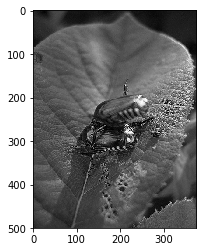

In [2]:
import dlinputs; reload(dlinputs); dli = dlinputs
data = dli.itdirtree("testdata/dirdata", "png,cls", size=6) | \
       dli.itmap(png=dli.pilreads, cls=int)
sample = data.next()
imshow(sample["png"])

## Basename Lists

In [3]:
!sed 5q testdata/dirdata.list

dirdata/10
dirdata/12
dirdata/13
dirdata/15
dirdata/18


got 6 samples
['__path__', 'png', 'cls']
/work/dlinputs/testdata/dirdata/18


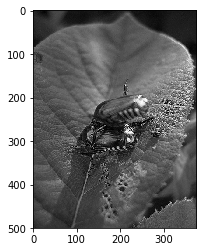

In [4]:
data = dli.itbasenames("testdata/dirdata.list", "png,cls", size=6) | \
       dli.itmap(png=dli.pilreads, cls=int)
sample = data.next()
print sample.keys()
print sample["__path__"]
imshow(sample["png"])

## Making Basename Lists

In [5]:
!find testdata/dirdata -name '*.png' > basenames
!sed 3q basenames

testdata/dirdata/10.png
testdata/dirdata/18.png
testdata/dirdata/15.png


got 6 samples
['__path__', 'png', 'cls']
/work/dlinputs/testdata/dirdata/10


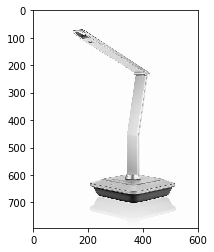

In [6]:
data = dli.itbasenames("basenames", "png,cls", size=6) | \
       dli.itmap(png=dli.pilreads, cls=int)
sample = data.next()
print sample.keys()
print sample["__path__"]
imshow(sample["png"])

## Tabular Dataset Descriptions

In [7]:
!sed 5q testdata/dirdata.tsv

dirdata/10.png	dirdata/10.cls
dirdata/12.png	dirdata/12.cls
dirdata/13.png	dirdata/13.cls
dirdata/15.png	dirdata/15.cls
dirdata/18.png	dirdata/18.cls


got 6 samples
['__path__png', '__path__cls', 'png', 'cls']
/work/dlinputs/testdata/dirdata/13.png


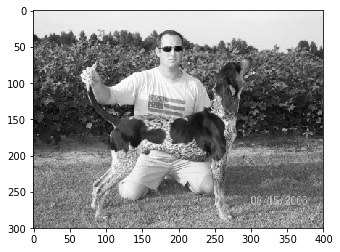

In [8]:
data = dli.ittabular("testdata/dirdata.tsv", "png,cls", size=6) | \
       dli.itmap(png=dli.pilreads, cls=int)
sample = data.next()
print sample.keys()
print sample["__path__png"]
imshow(sample["png"])

## Inline Data in Tabular Datasets

In [9]:
!sed 5q testdata/dirdata.tsv2

dirdata/10.png	304
dirdata/12.png	551
dirdata/13.png	180
dirdata/15.png	165
dirdata/18.png	625


got 6 samples
['__path__png', '_cls', 'png']
/work/dlinputs/testdata/dirdata/13.png


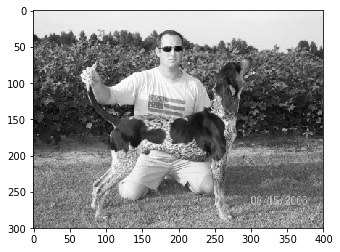

In [10]:
data = dli.ittabular("testdata/dirdata.tsv2", "png,_cls", size=6) | \
       dli.itmap(png=dli.pilreads, _cls=int)
sample = data.next()
print sample.keys()
print sample["__path__png"]
imshow(sample["png"])

## Search Paths

In [11]:
path = "/work/DATABASES:./testdata"
dli.find_file(path, "sample.db", verbose=True)

trying /work/DATABASES/sample.db
trying ./testdata/sample.db


'./testdata/sample.db'

In [12]:
path = "/work:./testdata"
dli.find_directory(path, "dirdata", "10.png", verbose=True)

trying /work/dirdata
trying ./testdata/dirdata
testing ./testdata/dirdata/10.png


'./testdata/dirdata'

# Database Reader

Sqlite databases are convenient for local datasets. They can be up to several terabytes large. `itsqlite` returns dictionaries containing
each column as a field.

In [13]:
!sqlite3 testdata/sample.db .schema

CREATE TABLE train (image blob, cls integer, inx integer);


6


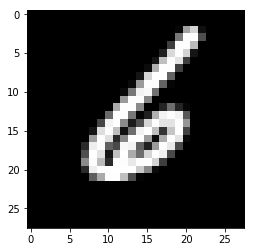

In [14]:
data = (dli.itsqlite("testdata/sample.db") |
        dli.itmap(image=dli.pilgray, cls=int))
for sample in data:
    imshow(sample["image"])
    print sample["cls"]
    break

# Tar Record Files

Tar record files are regular tar files. 

In [15]:
!tar -ztvf testdata/sample.tgz | sed 5q

-rw-r--r-- tmb/tmb           1 1970-01-01 00:00 10.cls
-rw-r--r-- tmb/tmb         306 1970-01-01 00:00 10.png
-rw-r--r-- tmb/tmb           1 1970-01-01 00:00 11.cls
-rw-r--r-- tmb/tmb         345 1970-01-01 00:00 11.png
-rw-r--r-- tmb/tmb           1 1970-01-01 00:00 12.cls
tar: write error


Consecutive files with the same
basename are returned as items in a dictionary; the extension is used
as the key to each entry.

In [16]:
data = dli.ittarreader("testdata/sample.tgz")
for sample in data:
    print sample.keys()
    print sample["__key__"]
    print repr(sample["cls"])
    print repr(sample["png"])[:30]
    break

['png', '__key__', 'cls']
10
'0'
'\x89PNG\r\n\x1a\n\x00\x00\x00


Usually, the output from an `ittarreader` is piped through something that decodes the string/buffer fields (`itmap`) and renames fields (`itren`). Decoders in `itmap` are just functions that map the contents of a field to new contents. The `dli.pilgray` function decodes a PNG-compressed image into a grayscale image represented as a numpy rank 2 array.

0


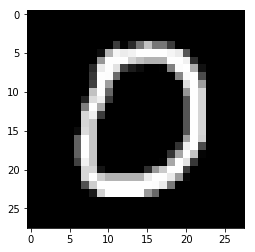

In [17]:
data = (dli.ittarreader("testdata/sample.tgz") |
        dli.itmap(png=dli.pilgray, cls=int) |
        dli.itren(image="png", cls="cls"))
for sample in data:
    imshow(sample["image"])
    print sample["cls"]
    break

The `ittarreader` can also read from URLs. This can be any web server, although often it is an S3-compatible storage server like Minio, Minio XL, Ceph, or Swift.

For desktop installations, the local Minio server is convenient.

In [18]:
!/bin/bash -c 'cd testdata && nohup python -m SimpleHTTPServer 9000 &'

nohup: appending output to 'nohup.out'


0


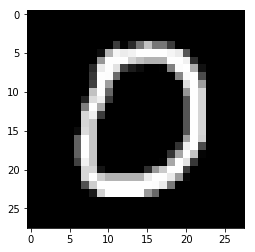

In [19]:
data = (dli.ittarreader("http://localhost:9000/sample.tgz") |
        dli.itmap(png=dli.pilgray, cls=int))
for sample in data:
    imshow(sample["png"])
    print sample["cls"]
    break

# Sharded Files

For larger datasets, sharding is a good idea. Shards are stored in JSON-formatted URLs.

In [20]:
!wget -O - http://localhost:9000/imagenet.shards | sed 10q

--2017-08-18 21:47:57--  http://localhost:9000/imagenet.shards
Resolving localhost (localhost)... 127.0.0.1, ::1
Connecting to localhost (localhost)|127.0.0.1|:9000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105 [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>]     105  --.-KB/s    in 0s      

{
    "metadata": {
    },
    "shards": [
        [
            "imagenet-000000.tgz"
        ]
    ]
}
2017-08-18 21:47:57 (26.9 MB/s) - written to stdout [105/105]



Decoding is otherwise just like regular `ittarfile`. Note that the shard reader randomizes shard order by default.

trying: http://localhost:9000/imagenet.shards
304


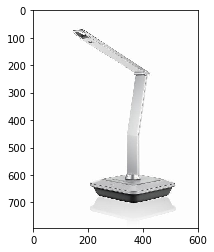

In [21]:
data = (dli.ittarshards("http://localhost:9000/imagenet.shards") |
        # dli.itinfo() |
        dli.itmap(png=dli.pilrgb, cls=int))
for sample in data:
    imshow(sample["png"])
    print sample["cls"]
    break

To make input pipelines movable between different environments, you can also specify an `urlpath`, a list of URL roots to search (you can also supply these as a whitespace separated string).

trying: http://mars:9000/imagenet.shards
FAILED
trying: http://jupiter:9000/imagenet.shards
FAILED
trying: http://localhost:9000/imagenet.shards
304


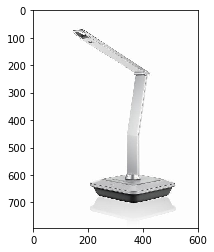

In [22]:
urlpath = """
http://mars:9000/
http://jupiter:9000/
http://localhost:9000/
""".strip().split()

data = (dli.ittarshards("imagenet.shards", urlpath=urlpath) | \
        dli.itmap(png=dli.pilrgb, cls=int))
for sample in data:
    imshow(sample["png"])
    print sample["cls"]
    break

# Other Input Filters

There are more pipeline components:

- `itshuffle` shuffles samples inline
- `itstandardize` performs image size standardization
- `itbatch` performs batching of inputs

More are being added to `dlpipes`, including in-memory and on-disk caching, more data augmentation, and distributed and parallel pipes.

trying: http://localhost:9000/imagenet.shards
(5, 256, 256, 3)
[551 165 180 304 625]


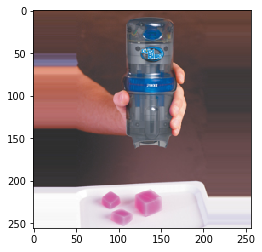

In [23]:
data = (dli.ittarshards("http://localhost:9000/imagenet.shards") |
        dli.itshuffle(1000) |
        dli.itmap(png=dli.pilrgb, cls=int) |
        dli.itren(image="png", cls="cls") |
        dli.itstandardize((256,256)) |
        dli.itbatch(5))
for sample in data:
    print sample["image"].shape
    imshow(sample["image"][0])
    print sample["cls"]
    break

# Loadable Inputs and Models

In many applications, it's useful to separate the input pipelines and model definitions from the source code of the application. The `dlpipes.loadable` module addresses this problem. It allows input pipelines and models to be defined with arbitrary Python code, but to be imported by file name rather than using the `import` statement.

In [24]:
!cat input-sample.py

#!/usr/bin/python

import dlinputs as dli

class Inputs(object):
    def training_data(self, **kw):
        return dli.itsqlite("testdata/sample.db", **kw) | \
               dli.itmap(image=dli.pilreads, cls=int)


Note that loadable input pipelines can be written using arbitrary Python code; they simply need to return Python iterators.

Different partitions of the dataset may get different `*_data` methods. You generally should have at least `training_data` and `test_data`. All and only datasets should have methods ending in `_data`.

Loadable input pipelines and models written in Python must end in `.py`; that's because the loader will eventually also load JSON and YAML definitions of pipelines and models.

In [25]:
factory = dli.loadable.load_input("input-sample.py")
training_data = factory.training_data()
training_data.next().keys()

['image', 'inx', '__epoch__', 'cls']

Defining dataset iterators in this way allows us to create useful tools that operate over datasets. For example, `show-input` provides information about a dataset iterators; optionally, it can also benchmark. There are other tools for broadcasting datasets over the network, dumping them into sharded files, etc.

In [26]:
!./show-input input-sample.py

datasets: training
showing: training

      __epoch__ 0
            cls 6
          image (28, 28) [0.0,1.0] 0.128111(0.300329773671)
            inx 999


# Client Server Pipelines

It is often useful to run some preprocessing code distributed on multiple CPU-only servers, then send the data on to the deep learning model on a GPU machine. The `zmqserver` and `itzmq` functions make this easy. These functions use a simple and time-efficient encoding of tensors in multipart ZMQ messages. With `itzmq`, it is also easily possible to connect to ZMQ-based servers written in other languages, to build efficient PUB/SUB training pipelines for training many models simultaneously, to build efficient wide area distribution trees for training data across data centers.

In [27]:
%%writefile server.py
import dlinputs as dli
data = dli.ittarreader("testdata/sample.tgz") | \
       dli.itmap(png=dli.pilrgb, cls=int)
dli.zmqserver(data, bind="tcp://*:17006")

Overwriting server.py


In [28]:
!/bin/bash -c 'python ./server.py &'

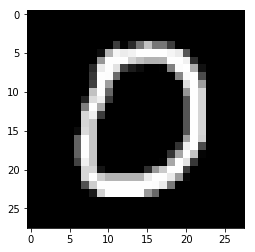

In [29]:
data = dli.itzmq(connect="tcp://localhost:17006")
imshow(data.next()["png"])

# Parallelizing Input Pipelines

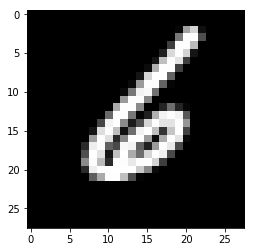

In [30]:
def factory():
    return dli.itsqlite("testdata/sample.db") | \
           dli.itmap(image=dli.pilreads, cls=int)
data = factory()
imshow(data.next()["image"])

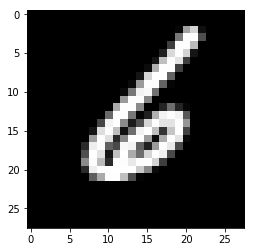

In [31]:
data = dli.parallel.parallelize_input(factory, 4)
imshow(data.next()["image"])